In [1]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.7 MB/s 


In [2]:
# Standard libraries imports
import requests
import numpy as np
import pandas as pd
from scipy import stats
import pyarabic.araby as araby

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# list of all Arabic characters
chars = list('اٱبتةثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىی')
print('Number of Arabic Characters:', len(chars))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(chars))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(chars))

char_to_index['p'] = 0 # pad
char_to_index['s'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = 'p' # pad
index_to_char[1] = 's' # separator
index_to_char[2] = '_' # mask

# additional char_to_index and index_to_char extracted manually as shown in next 
# cells. They were extracted and then saved into a CSV file
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1lQFU7XFy82-1dE5kPK7yDLpJ6tleycCC')
chars_2 = df['char'].values.tolist()
indexes_2 = df['value'].values.tolist()
del df

# additional character to index dictionary
char_to_index_2 = dict(zip(chars_2, indexes_2))
# additional index to character dictionary
index_to_char_2 = dict(zip(indexes_2, chars_2))

Number of Arabic Characters: 38


In [4]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [5]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


# Helper Functions

In [6]:
def indexes_to_word(example):
  '''
  Args: an array of indexes
  Returns: a list of characters
  '''
  example = example.tolist()
  list_of_chars = [index_to_char[idx] for idx in example]
  return list_of_chars

In [7]:
def final_prediction_as_chars(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of characters of the predictions from the start to the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  example = np.int32(predicted_flipped_example).tolist()
  # convert indexes into characters
  pred_chars = [index_to_char[i] for i in example]
  # if gold is required, return it
  if return_gold:
    gold = list(valid_df.iloc[index, 1])
    return pred_chars, gold
  return pred_chars

In [8]:
def final_prediction_as_indexes(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of indexes of the predictions from the start to the index of the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  pred_indexes = np.int32(predicted_flipped_example).tolist()
  # if gold is required, return it
  if return_gold:
    gold = [char_to_index[char] for char in list(valid_df.iloc[index, 1])]
    return pred_indexes, gold
  return pred_indexes

In [9]:
def arabic_leven_dis(gold, pred, return_matrix=False):
  '''
  Levenshtein distance
  Args:
    gold: list of indexes of the gold characters
    pred: list of indexes of the predicted characters
  Returns:
    Levenshtein distance
  '''

  # construct a matrix of the correct size
  sol = np.zeros((len(pred), len(gold)))

  # first row and column
  sol[0, :] = np.flip([i for i in range(len(gold))])
  sol[:, -1] = [i for i in range(len(pred))]

  # fill in the rest
  # through every column
  for c in reversed(range(len(gold) - 1)):
    # through every row
    for r in range(1, len(pred)):

      # in case not the same corresponding letters, take the minimum value of the above right corner three values (Arabic) + 1 
      if gold[c] != pred[-(r+1)]:
        sol[r, c] = min(sol[r-1, c+1], sol[r-1, c], sol[r, c+1]) + 1
      # in case the corresponding letters are the same, take the upper diagonal value
      else:
        sol[r, c] = sol[r-1, c+1]

  # if the full matrix is required
  if return_matrix: 
    return sol
  # if only the minimum number of edits is required
  return sol[-1, 0]

In [10]:
# load the predictions
url = 'https://drive.google.com/uc?export=download&id=1VbSc6ptY_v4M0g5_XexihuYgvM4D5xTl'
r = requests.get(url, allow_redirects=True)
open('validation_set_prediction_2.npy', 'wb').write(r.content)
# read the predictions NumPy array
with open('/content/validation_set_prediction_2.npy', 'rb') as f:
  preds = np.load(f)

In [11]:
# construct a distances list
distances = []
# iterate over each plural example in the validation set
for i in range(len(valid_df)):
  # extract the final predicted indexes alongside with the ground truth ones
  pred, gold = final_prediction_as_indexes(i, True)
  gold = gold + [-1] # add -1 for the '#' in the Levenshtein distance
  pred = pred + [-1] # add -1 for the '#' in the Levenshtein distance
  # calculate the minimum edits required
  dist = arabic_leven_dis(gold, pred)
  # append the distance to the distances list
  distances.append(dist)

# convert the distances list into a NumPy array
distances = np.array(distances)

In [12]:
# print the statistics of the distances array
statistics = stats.describe(distances)
statistics

DescribeResult(nobs=343, minmax=(0.0, 7.0), mean=1.629737609329446, variance=1.888820691183742, skewness=0.30677260472592827, kurtosis=-0.5883381593958732)

In [13]:
# display additional statistics using Pandas methods
pd.DataFrame({'dist': distances}).describe()

,dist
count,343.000000
mean,1.629738
std,1.374344
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,7.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


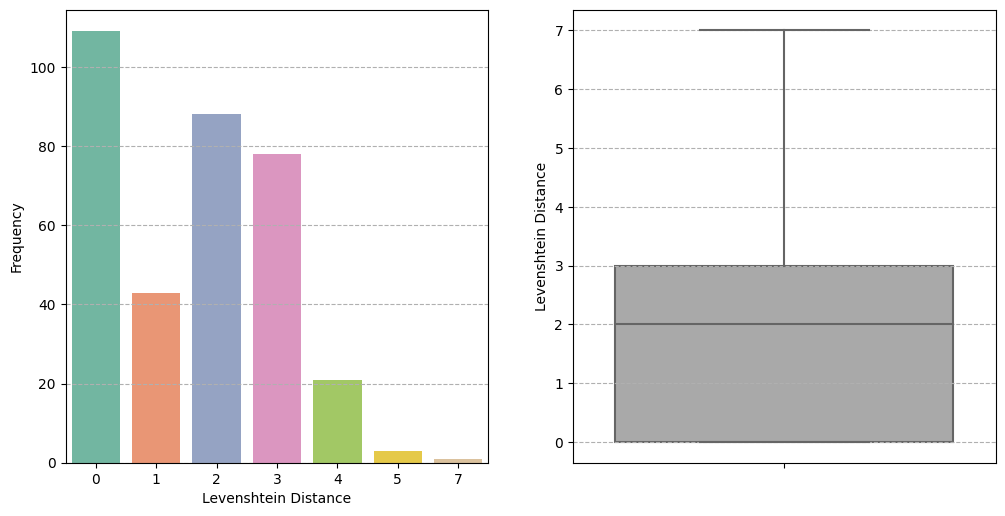

In [14]:
plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(1, 2, 1)
# plot a figure showing the frequencies of each distance value
sns.countplot(np.int32(distances), palette="Set2")
# plt.box(False)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Frequency')
plt.title('')
plt.grid(linestyle='dashed', alpha=1, axis='y')
plt.subplot(1, 2, 2)
# plot a box plot that shows the distribution of distances
sns.boxplot(y=distances, color='darkgrey')
plt.ylabel('Levenshtein Distance')
# plt.box(False)
plt.grid(linestyle='dashed', alpha=1, axis='y')
plt.savefig('frequency.jpg', dpi=100, bbox_inches='tight');

In [15]:
# the whole dataset
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(valid_df.iloc[:, -1].values.tolist()):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 146
Number of masculine examples: 50
Number of takseer examples: 147


# Intensive Study

In [16]:
# print(count of each Levenshtein distance)
dists = np.unique(np.int32(distances), return_counts=True)[0]
couts = np.unique(np.int32(distances), return_counts=True)[1]
display(pd.DataFrame({'Distance': dists, 'Counts': couts}))

,Distance,Counts
0,0,109
1,1,43
2,2,88
3,3,78
4,4,21
5,5,3
6,7,1


In [17]:
# group by each distance value
zero_distance_indexes = np.where(distances==0)[0]
one_distance_indexes = np.where(distances==1)[0]
two_distance_indexes = np.where(distances==2)[0]
three_distance_indexes = np.where(distances==3)[0]
four_distance_indexes = np.where(distances==4)[0]
five_distance_indexes = np.where(distances==5)[0]
six_distance_indexes = np.where(distances==6)[0] # empty list (no examples lie in this range)
seven_distance_indexes = np.where(distances==7)[0]

## Zero Levenshtein Distance (Perfect Match) 

In [18]:
# extract a list of the plural forms
zero_distance_plural = valid_df.iloc[zero_distance_indexes, -1].values.tolist()

In [19]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(zero_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 68
Number of masculine examples: 17
Number of takseer examples: 24


In [20]:
# retrieving takseer examples
takseer_examples = [zero_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [21]:
# retrieving feminine examples
feminine_examples = [zero_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

مشاركات is in training set
مستوطنات is in training set
**************************************************
2 out of 68 words is/are in the training set


In [22]:
# retrieving masculine examples
masculine_examples = [zero_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

مستخدمين is in training set
**************************************************
1 out of 17 words is/are in the training set


## One Levenshtein Distance

In [23]:
# extract a list of the plural forms
one_distance_plural = valid_df.iloc[one_distance_indexes, -1].values.tolist()

In [24]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(one_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 19
Number of masculine examples: 8
Number of takseer examples: 16


In [25]:
# retrieving takseer examples
takseer_examples = [one_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [26]:
# retrieving feminine examples
feminine_examples = [one_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [27]:
# retrieving masculine examples
masculine_examples = [one_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Two Levenshtein Distance

In [28]:
# extract a list of the plural forms
two_distance_plural = valid_df.iloc[two_distance_indexes, -1].values.tolist()

In [29]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(two_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 35
Number of masculine examples: 10
Number of takseer examples: 43


In [30]:
# retrieving takseer examples
takseer_examples = [two_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [31]:
# retrieving feminine examples
feminine_examples = [two_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

مجريات is in training set
**************************************************
1 out of 35 words is/are in the training set


In [32]:
# retrieving masculine examples
masculine_examples = [two_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Three Levenshtein Distance

In [33]:
# extract a list of the plural forms
three_distance_plural = valid_df.iloc[three_distance_indexes, -1].values.tolist()

In [34]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(three_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 20
Number of masculine examples: 11
Number of takseer examples: 47


In [35]:
# retrieving takseer examples
takseer_examples = [three_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [36]:
# retrieving feminine examples
feminine_examples = [three_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [37]:
# retrieving masculine examples
masculine_examples = [three_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Four Levenshtein Distance

In [38]:
# extract a list of the plural forms
four_distance_plural = valid_df.iloc[four_distance_indexes, -1].values.tolist()

In [39]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(four_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 4
Number of masculine examples: 4
Number of takseer examples: 13


In [40]:
# retrieving takseer examples
takseer_examples = [four_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [41]:
# retrieving feminine examples
feminine_examples = [four_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [42]:
# retrieving masculine examples
masculine_examples = [four_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Five Levenshtein Distance

In [43]:
# extract a list of the plural forms
five_distance_plural = valid_df.iloc[five_distance_indexes, -1].values.tolist()

In [44]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(five_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 0
Number of masculine examples: 0
Number of takseer examples: 3


In [45]:
# retrieving takseer examples
takseer_examples = [five_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [46]:
# retrieving feminine examples
feminine_examples = [five_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [47]:
# retrieving masculine examples
masculine_examples = [five_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Seven Levenshtein Distance

In [48]:
# extract a list of the plural forms
seven_distance_plural = valid_df.iloc[seven_distance_indexes, -1].values.tolist()

In [49]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(seven_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 0
Number of masculine examples: 0
Number of takseer examples: 1


In [50]:
# retrieving takseer examples
takseer_examples = [seven_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [51]:
# retrieving feminine examples
feminine_examples = [seven_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [52]:
# retrieving masculine examples
masculine_examples = [seven_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Visualization

In [53]:
# create a dictionary that contains the examples of each distance value
dict_ = dict()
dict_['zero_distance_plural'] = valid_df.iloc[zero_distance_indexes, -1].values.tolist()
dict_['one_distance_plural'] = valid_df.iloc[one_distance_indexes, -1].values.tolist()
dict_['two_distance_plural'] = valid_df.iloc[two_distance_indexes, -1].values.tolist()
dict_['three_distance_plural'] = valid_df.iloc[three_distance_indexes, -1].values.tolist()
dict_['four_distance_plural'] = valid_df.iloc[four_distance_indexes, -1].values.tolist()
dict_['five_distance_plural'] = valid_df.iloc[five_distance_indexes, -1].values.tolist()
dict_['seven_distance_plural'] = valid_df.iloc[seven_distance_indexes, -1].values.tolist()

# create a list to hold the counts across distances
feminine_counts_list = []
masculine_counts_list = []
takseer_counts_list = []

for key in [*dict_]:
  # count the masculine, feminine, and takseer forms based on the word endings
  feminine_counts = 0
  masculine_counts = 0
  takseer_counts = 0
  # go over each word and check whether it is masculine, feminine, or takseer
  for i, word in enumerate(dict_[key]):
    if word[-2:] == 'ات':
      feminine_counts += 1
    elif word[-2:] == 'ين':
      masculine_counts += 1
    else:
      takseer_counts += 1
  # append counts for each category
  feminine_counts_list.append(feminine_counts)
  masculine_counts_list.append(masculine_counts)
  takseer_counts_list.append(takseer_counts)

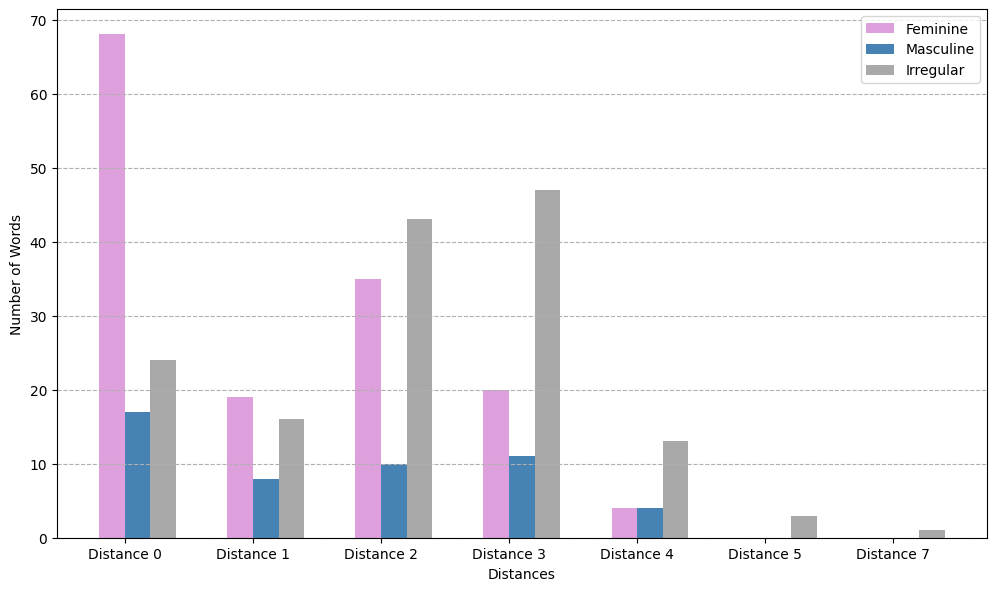

In [54]:
# plot a bar chart showing the distribution of the three classes in 
# distance value
plt.figure(figsize=(12, 7), dpi=100)
X = [f'Distance {i}' for i in range(8) if i != 6]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.1, feminine_counts_list, 0.2, label = 'Feminine', color='plum')
plt.bar(X_axis + 0.1, masculine_counts_list, 0.2, label = 'Masculine', color='steelblue')
plt.bar(X_axis + 0.3, takseer_counts_list, 0.2, label = 'Irregular', color='darkgray')

  
plt.xticks(X_axis, X)
plt.xlabel("Distances")
plt.ylabel("Number of Words")
# plt.title("Number of Words in Each Distance Range")
plt.legend()
plt.grid(linestyle='dashed', axis='y')
plt.savefig('number of words in each distance range.jpg', dpi=100, bbox_inches='tight')

# Model Progress 

In [55]:
# read the saved training progress dataset
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16IkBKrjzTvzAS4hNCmkoRCm284GIwWEG')
cols = df.columns.tolist()
# rename the columns
cols = ['Train Loss', 'Train Accuracy', 'Train Top 5 Accuracy',
        'Valid Loss', 'Valid Accuracy', 'Valid Top 5 Accuracy']
df.columns = cols
df

,Train Loss,Train Accuracy,Train Top 5 Accuracy,Valid Loss,Valid Accuracy,Valid Top 5 Accuracy
0,129.729332,0.003550,0.095588,5.439922,0.036625,0.143230
1,124.469086,0.021552,0.132860,6.240949,0.061702,0.131164
2,119.895061,0.063387,0.174442,6.868495,0.064656,0.118113
3,118.806897,0.034990,0.110294,6.378825,0.106891,0.203718
4,105.124122,0.056288,0.159990,6.440104,0.074484,0.208504
...,...,...,...,...,...,...
95,0.989303,0.381592,0.391734,7.552056,0.266240,0.359112
96,0.978107,0.382099,0.391734,7.554486,0.266240,0.359112
97,0.967148,0.382099,0.391734,7.557542,0.266011,0.359112
98,0.956402,0.382099,0.391734,7.562794,0.265896,0.358997


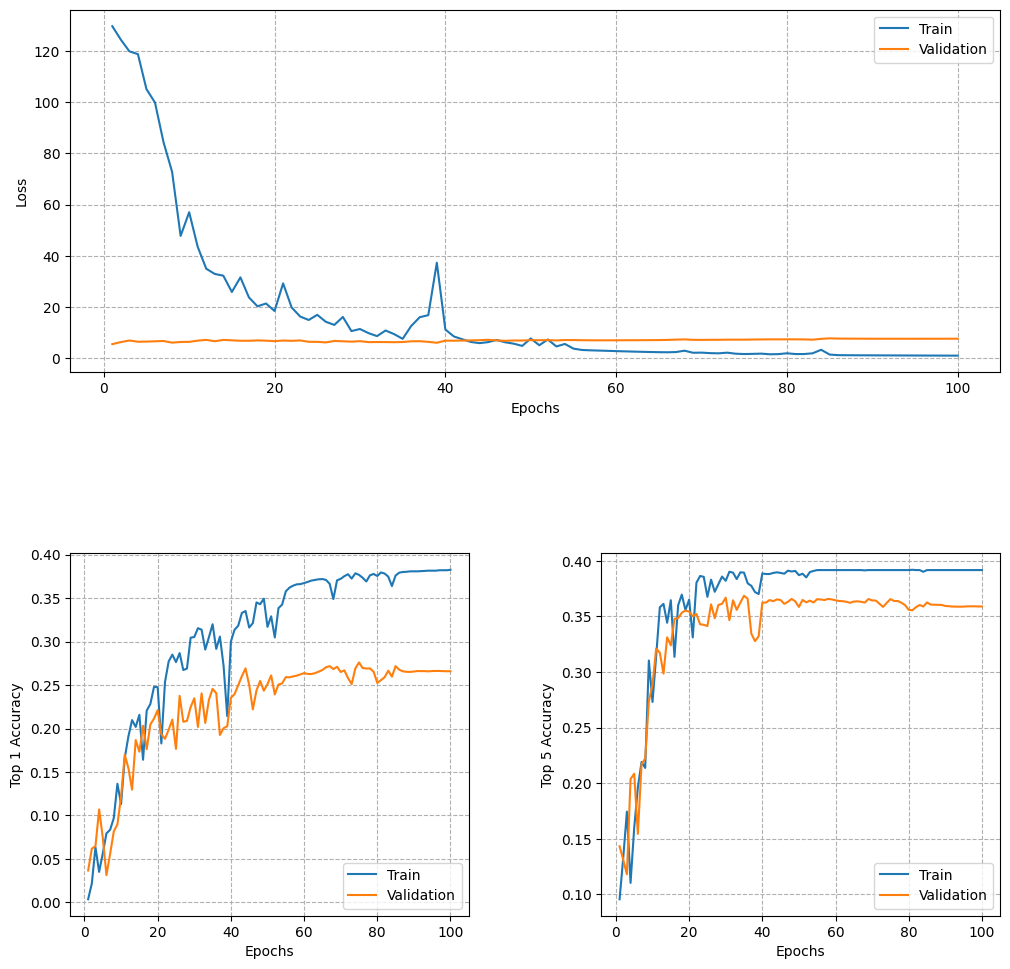

In [56]:
# plot loss vs epochs
plt.figure(figsize=(12, 12), dpi=100)
grid = plt.GridSpec(2, 4, wspace=1, hspace=0.5)
plt.subplot(grid[0, ::])
plt.plot(np.arange(1, 101), df['Train Loss'])
plt.plot(np.arange(1, 101), df['Valid Loss'])
plt.grid(linestyle='dashed')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(grid[1, :2])
# plot accuracy vs epochs
plt.plot(np.arange(1, 101), df['Train Accuracy'])
plt.plot(np.arange(1, 101), df['Valid Accuracy'])
plt.grid(linestyle='dashed')
plt.ylabel('Top 1 Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.subplot(grid[1, 2:])
# plot top 5 accuracy vs epochs
plt.plot(np.arange(1, 101), df['Train Top 5 Accuracy'])
plt.plot(np.arange(1, 101), df['Valid Top 5 Accuracy'])
plt.grid(linestyle='dashed')
plt.ylabel('Top 5 Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
# save figures
plt.savefig('metrics.jpg', dpi=100, bbox_inches='tight');